# Simple regression example

In this example, we consider the standard Boston housing dataset from Scikit-learn and implement some regression models.   

In [1]:
import os
#list the current work dir

#change the current work dir
os.chdir(os.getcwd())

In [2]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import mean_squared_error
from river import stream
from river import preprocessing, linear_model, optim
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
import time
import ray
from sail.ensemble.distEWARegressor import DistEWARegressor
from sail.ensemble.distAggregateRegressor import DistAggregateRegressor
import numpy as np


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt 


In [4]:
ray.init(local_mode=True)

print("Boston housing dataset prediction.")
boston = load_boston()
boston_data, boston_target = boston.data, boston.target

df_X = pd.DataFrame(boston_data, columns=boston.feature_names)
df_y = pd.Series(boston_target)

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)

stdScaler_many = preprocessing.StandardScaler()

model_many = linear_model.LinearRegression(
                 optimizer=optim.RMSProp())

dataset = stream.iter_pandas(X_train, y_train)

stdScaler_many.learn_many(X_train)
X_train = stdScaler_many.transform_many(X_train)

X_train.head()
print(type(X_train), type(y_train))

Boston housing dataset prediction.
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


/Users/dhaval/.pyenv/versions/3.8.12/envs/venv-sail/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets inc

In [4]:
optimizers = [optim.SGD(0.01), optim.RMSProp(), optim.AdaGrad()]

hedge = DistAggregateRegressor(estimators=[linear_model.LinearRegression(optimizer=o, intercept_lr=.1)
                                         for o in optimizers],
                             learning_rate=0.005)

for xi, yi in stream.iter_array(X_train.to_numpy(), y_train.to_numpy(), feature_names=list(X_train.columns)):
    xi = np.array([np.fromiter(xi.values(), dtype=float)])
    yi = np.array([yi])
    start = time.time()
    hedge.partial_fit(xi,yi) 
    # hedge.partial_fit(x, yi)

print("duration =", time.time() - start, "\nresult = ", sum)



duration = 0.0061457157135009766 
result =  <built-in function sum>


In [5]:
for i in range(2):    
    for xi, yi in stream.iter_array(X_train.to_numpy(), y_train.to_numpy(), feature_names=list(X_train.columns)):
        xi = np.array([np.fromiter(xi.values(), dtype=float)])
        yi = np.array([yi])
        start = time.time()
        hedge.partial_fit(xi,yi) 
        # hedge.partial_fit(x, yi)

print("duration =", time.time() - start, "\nresult = ", sum)




duration = 0.006087779998779297 
result =  <built-in function sum>


In [11]:
x = X_test
x = stdScaler_many.transform_many(x)
start = time.time()
ypred_hedge = hedge.predict(x)
print("duration =", time.time() - start, "\nresult = ", sum)

mse = mean_squared_error(y_test, ypred_hedge)
print("MSE_hedge: ", mse)
print("RMSE_hedge: ", mse**(1/2.0))






duration = 0.011426210403442383 
result =  <built-in function sum>
MSE_hedge:  24.118947950037473
RMSE_hedge:  4.911104554989384


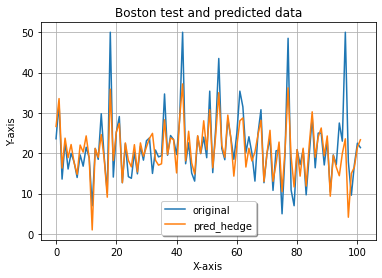

In [10]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, ypred_hedge, label="pred_hedge")
# plt.plot(x_ax, ypred_one, label="pred_one")
# plt.plot(x_ax, ypred_many, label="pred_many")
# plt.plot(x_ax, ypred_sk, label="pred_sk")
plt.title("Boston test and predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()